In [1]:
import numpy as np
import pandas as pd
import requests as req
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import re
import matplotlib
from sklearn.cluster import KMeans
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [38]:
f1 = 'US_CDI.csv'  # US Chronic Disease Indicators
f2 = 'US_LCD.csv'  # US Leading Causes of Death
cdiData = open(f1, 'r')
lcdData = open(f2, 'r')
cdi_df = pd.read_csv(cdiData)
lcd_df = pd.read_csv(lcdData)
cdiData.close()
lcdData.close()

#cleaning cdi_df
#some columns are empty, so dropping them
to_drop = ['StratificationCategoryID2', 'StratificationID2', 'StratificationCategoryID3', 'StratificationID3',
          'StratificationCategory2', 'Stratification2', 'StratificationCategory3', 'Stratification3',
          'Response']

cdi_df.drop(to_drop, inplace=True, axis=1)

cdi_df.head()
#this is the code to dl the CSVs from the site directly
#but the files are pretty large, so might not wnat to do that
#url = 'https://chronicdata.cdc.gov/views/g4ie-h725/rows.csv?accessType=DOWNLOAD'
#cr = pd.read_csv(url), also need to specify dtype for some columns on this part

,YearStart,YearEnd,LocationAbbr,LocationDesc,DataSource,Topic,Question,DataValueUnit,DataValueType,DataValue,DataValueAlt,DataValueFootnoteSymbol,DatavalueFootnote,LowConfidenceLimit,HighConfidenceLimit,StratificationCategory1,Stratification1,GeoLocation,ResponseID,LocationID,TopicID,QuestionID,DataValueTypeID,StratificationCategoryID1,StratificationID1
0,2016,2016,US,United States,BRFSS,Alcohol,Binge drinking prevalence among adults aged >=...,%,Crude Prevalence,16.9,16.9,*,50 States + DC: US Median,16.0,18.0,Overall,Overall,NaN,NaN,59,ALC,ALC2_2,CRDPREV,OVERALL,OVR
1,2016,2016,AL,Alabama,BRFSS,Alcohol,Binge drinking prevalence among adults aged >=...,%,Crude Prevalence,13.0,13.0,NaN,NaN,11.9,14.1,Overall,Overall,"(32.84057112200048, -86.63186076199969)",NaN,1,ALC,ALC2_2,CRDPREV,OVERALL,OVR
2,2016,2016,AK,Alaska,BRFSS,Alcohol,Binge drinking prevalence among adults aged >=...,%,Crude Prevalence,18.2,18.2,NaN,NaN,16.0,20.6,Overall,Overall,"(64.84507995700051, -147.72205903599973)",NaN,2,ALC,ALC2_2,CRDPREV,OVERALL,OVR
3,2016,2016,AZ,Arizona,BRFSS,Alcohol,Binge drinking prevalence among adults aged >=...,%,Crude Prevalence,15.6,15.6,NaN,NaN,14.3,16.9,Overall,Overall,"(34.865970280000454, -111.76381127699972)",NaN,4,ALC,ALC2_2,CRDPREV,OVERALL,OVR
4,2016,2016,AR,Arkansas,BRFSS,Alcohol,Binge drinking prevalence among adults aged >=...,%,Crude Prevalence,15.0,15.0,NaN,NaN,13.0,17.2,Overall,Overall,"(34.74865012400045, -92.27449074299966)",NaN,5,ALC,ALC2_2,CRDPREV,OVERALL,OVR


In [29]:
# display(lcd_df)
lcd_df.head()

,Year,113 Cause Name,Cause Name,State,Deaths,Age-adjusted Death Rate
0,2016,"Accidents (unintentional injuries) (V01-X59,Y8...",Unintentional injuries,Alabama,2755,55.5
1,2016,"Accidents (unintentional injuries) (V01-X59,Y8...",Unintentional injuries,Alaska,439,63.1
2,2016,"Accidents (unintentional injuries) (V01-X59,Y8...",Unintentional injuries,Arizona,4010,54.2
3,2016,"Accidents (unintentional injuries) (V01-X59,Y8...",Unintentional injuries,Arkansas,1604,51.8
4,2016,"Accidents (unintentional injuries) (V01-X59,Y8...",Unintentional injuries,California,13213,32.0


In [30]:
#This graph shows which chronic disease appear most in the histogram
pd.value_counts(cdi_df['Topic']).plot(kind='barh',figsize=(20,10), title='Chronic Disease Frequency')

TypeError: 'NoneType' object is not subscriptable

In [31]:
#make a new df for lcd that only contains data data from Causes of diabetes, cancer, and kidney disease
modified_lcd_df1 = lcd_df[lcd_df["Cause Name"].str.contains('Diabetes')]
modified_lcd_df1 = modified_lcd_df1.append(lcd_df[lcd_df["Cause Name"].str.contains('Cancer')])
modified_lcd_df1 = modified_lcd_df1.append(lcd_df[lcd_df["Cause Name"].str.contains('Kidney')])

#Group by state and cause of death and then sum occurences of death
modified_lcd_df1 = modified_lcd_df1.groupby(['State','Cause Name']).sum()

# Remove unwanted Data
modified_lcd_df1 = modified_lcd_df1.drop(['Year', 'Age-adjusted Death Rate'], axis=1)
modified_lcd_df1 = modified_lcd_df1.drop(index='United States')

modified_lcd_df1

Deaths
State                Cause Name             
Alabama              Cancer           180780
                     Diabetes          24143
                     Kidney disease    18899
Alaska               Cancer            15032
                     Diabetes           1790
                     Kidney disease      729
Arizona              Cancer           184958
                     Diabetes          25235
                     Kidney disease     9361
Arkansas             Cancer           115074
                     Diabetes          15028
                     Kidney disease    11453
California           Cancer          1002719
                     Diabetes         133769
                     Kidney disease    48386
Colorado             Cancer           121844
                     Diabetes          13446
                     Kidney disease     7759
Connecticut          Cancer           124327
                     Diabetes          12413
                     Kidney disease    10272
Delaware             Cancer            33217
                     Diabetes           3847
                     Kidney disease     2681
District of Columbia Cancer            20865
                     Diabetes           3016
                     Kidney disease     1235
Florida              Cancer           737552
                     Diabetes          90131
                     Kidney disease    48353
Georgia              Cancer           270920
                     Diabetes          32463
                     Kidney disease    28517
Hawaii               Cancer            39557
                     Diabetes           4469
                     Kidney disease     3173
Idaho                Cancer            44027
                     Diabetes           6299
                     Kidney disease     2432
Illinois             Cancer           440324
                     Diabetes          51496
                     Kidney disease    43358
Indiana              Cancer           235052
                     Diabetes          31366
                     Kidney disease    23419
Iowa                 Cancer           115576
                     Diabetes          13833
                     Kidney disease     5211
Kansas               Cancer            97101
                     Diabetes          12385
                     Kidney disease     9838
Kentucky             Cancer           173977
                     Diabetes          22111
                     Kidney disease    16466
Louisiana            Cancer           167034
                     Diabetes          26445
                     Kidney disease    19913
Maine                Cancer            57029
                     Diabetes           6830
                     Kidney disease     4352
Maryland             Cancer           187172
                     Diabetes          24018
                     Kidney disease    12855
Massachusetts        Cancer           238031
                     Diabetes          22301
                     Kidney disease    22963
Michigan             Cancer           364097
                     Diabetes          49463
                     Kidney disease    29623
Minnesota            Cancer           168221
                     Diabetes          21235
                     Kidney disease    12565
Mississippi          Cancer           111950
                     Diabetes          14876
                     Kidney disease    12235
Missouri             Cancer           225835
                     Diabetes          26584
                     Kidney disease    21550
Montana              Cancer            35021
                     Diabetes           4526
                     Kidney disease     2149
Nebraska             Cancer            61435
                     Diabetes           8003
                     Kidney disease     4620
Nevada               Cancer            78794
                     Diabetes           6472
                     Kidney disease     7108
New Hampshire        Cancer      

In [32]:
#Preprocess data to make bargraph for Causes of Death in Each State
df = lcd_df[lcd_df["Cause Name"].str.contains('Diabetes')]
df = df.groupby('State').sum()
df = df.drop(['Year', 'Age-adjusted Death Rate'], axis=1)
df = df.drop(index='United States')
df = df.sort_values(by=['Deaths'])

modified_lcd_df2 = df.rename(columns={'Deaths': 'Diabetes Deaths'})

In [33]:
#Preprocessing...
df = lcd_df[lcd_df["Cause Name"].str.contains('Cancer')]
df = df.groupby('State').sum()
df = df.drop(['Year', 'Age-adjusted Death Rate'], axis=1)
df = df.drop(index='United States')
df = df.sort_values(by=['Deaths'])

modified_lcd_df2['Cancer Deaths'] = df['Deaths']

In [34]:
#Preprocess still
df = lcd_df[lcd_df["Cause Name"].str.contains('Kidney')]
df = df.groupby('State').sum()
df = df.drop(['Year', 'Age-adjusted Death Rate'], axis=1)
df = df.drop(index='United States')
df = df.sort_values(by=['Deaths'])

modified_lcd_df2['Kidney Disease Deaths'] = df['Deaths']

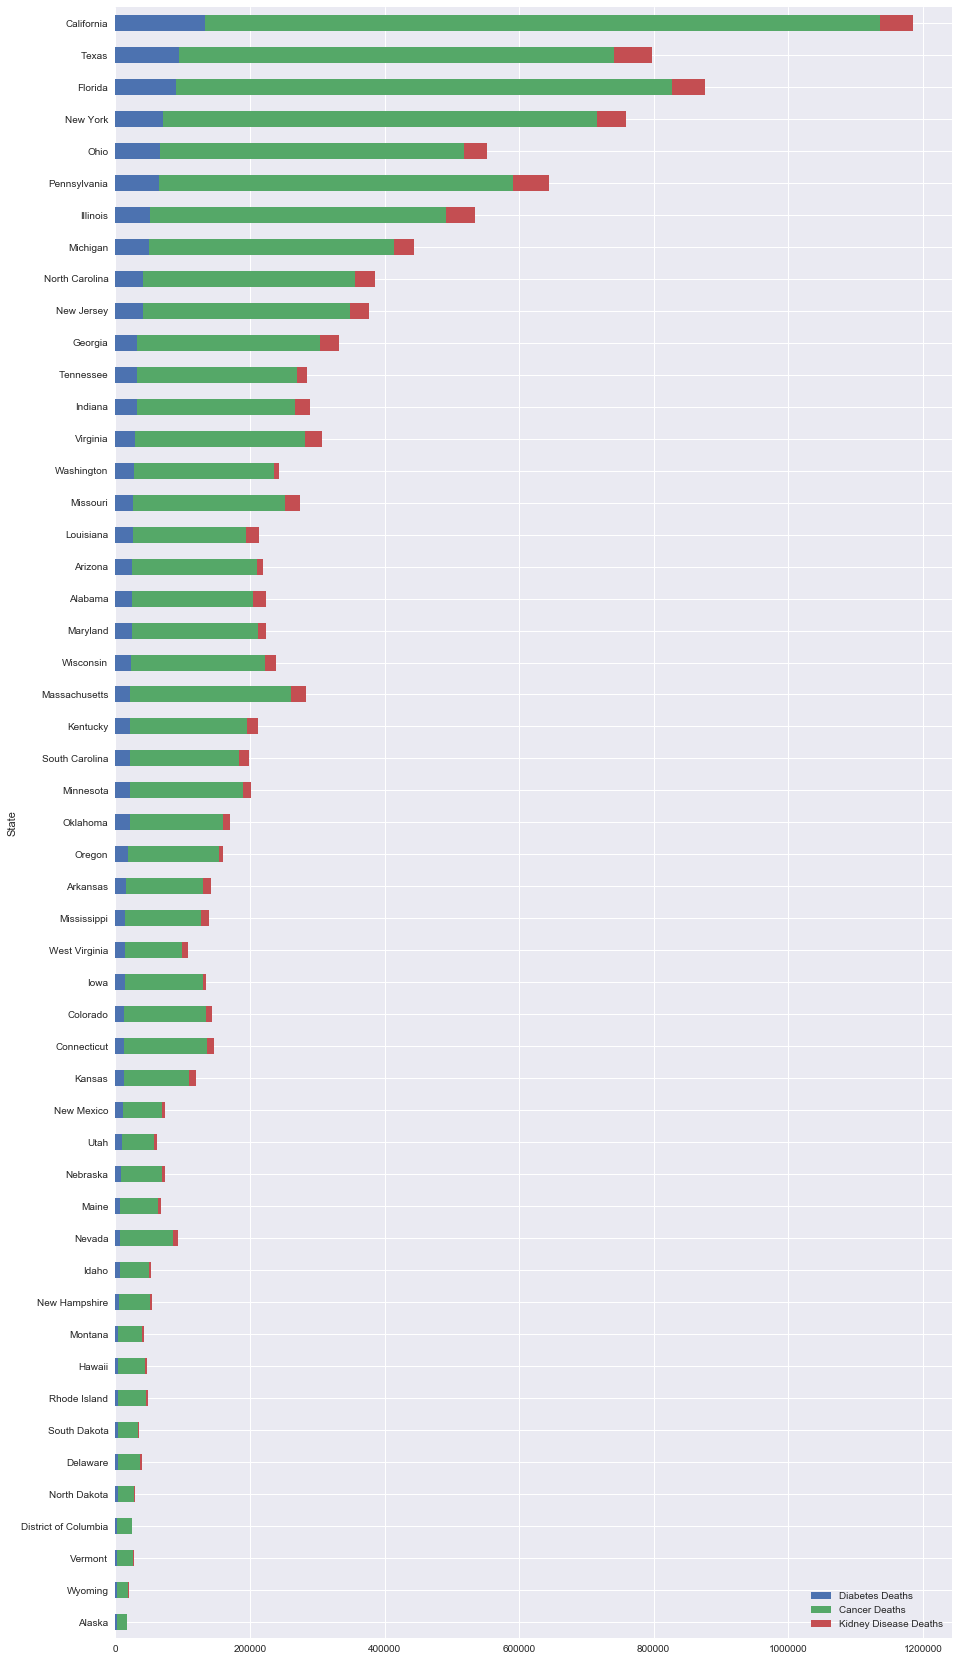

In [35]:
modified_lcd_df2.plot.barh(stacked=True,figsize=(15,30))

In [335]:
new_cdi = cdi_df[cdi_df["Topic"].str.contains('Alcohol')]
new_cdi = new_cdi[new_cdi["Stratification1"].str.contains("Female")]
new_cdi = new_cdi[new_cdi["DataValueType"].str.contains('Crude')]
new_cdi = new_cdi[new_cdi["Question"].str.contains("Binge drinking prevalence among adults aged >= 18 years")]
new_cdi_female = new_cdi[['LocationDesc', 'DataValue']].copy()
new_cdi_female = new_cdi_female.rename(columns={'LocationDesc':'States and Territories'})
new_cdi_female = new_cdi_female.sort_values(by=['DataValue'])

female_alcohol_cdi = new_cdi_female.rename(columns={'DataValue': '% Female Binge Drinkers (Crude Prevalence)'})

In [336]:
new_cdi = cdi_df[cdi_df["Topic"].str.contains('Alcohol')]
new_cdi = new_cdi[new_cdi["Stratification1"].str.contains("Male")]
new_cdi = new_cdi[new_cdi["DataValueType"].str.contains('Crude')]
new_cdi = new_cdi[new_cdi["Question"].str.contains("Binge drinking prevalence among adults aged >= 18 years")]
new_cdi_male = new_cdi[['LocationDesc', 'DataValue']].copy()
new_cdi_male = new_cdi_male.rename(columns={'LocationDesc':'States and Territories'})
new_cdi_male = new_cdi_male.sort_values(by=['DataValue'])

male_alcohol_cdi = new_cdi_male.rename(columns={'DataValue':'% Male Binge Drinkers (Crude Prevalence)'})

In [337]:
new_cdi2 = cdi_df[cdi_df["Topic"].str.contains('Alcohol')]
new_cdi2 = new_cdi2[new_cdi2["Stratification1"].str.contains("Female")]
new_cdi2 = new_cdi2[new_cdi2["DataValueType"].str.contains('Age-adjusted')]
new_cdi2 = new_cdi2[new_cdi2["Question"].str.contains("Binge drinking prevalence among adults aged >= 18 years")]
new_cdi_female2 = new_cdi2[['LocationDesc', 'DataValue']].copy()
new_cdi_female2 = new_cdi_female2.rename(columns={'LocationDesc':'States and Territories'})
new_cdi_female2 = new_cdi_female2.sort_values(by=['DataValue'])

female_alcohol_cdi2 = new_cdi_female2.rename(columns={'DataValue': '% Female Binge Drinkers (Age-Adjusted Prevalence)'})

In [338]:
new_cdi2 = cdi_df[cdi_df["Topic"].str.contains('Alcohol')]
new_cdi2 = new_cdi2[new_cdi2["Stratification1"].str.contains("Male")]
new_cdi2 = new_cdi2[new_cdi2["DataValueType"].str.contains('Age-adjusted')]
new_cdi2 = new_cdi2[new_cdi2["Question"].str.contains("Binge drinking prevalence among adults aged >= 18 years")]
new_cdi_male2 = new_cdi2[['LocationDesc', 'DataValue']].copy()
new_cdi_male2 = new_cdi_male2.rename(columns={'LocationDesc':'States and Territories'})
new_cdi_male2 = new_cdi_male2.sort_values(by=['DataValue'])

male_alcohol_cdi2 = new_cdi_male2.rename(columns={'DataValue': '% Male Binge Drinkers (Age-Adjusted Prevalence)'})

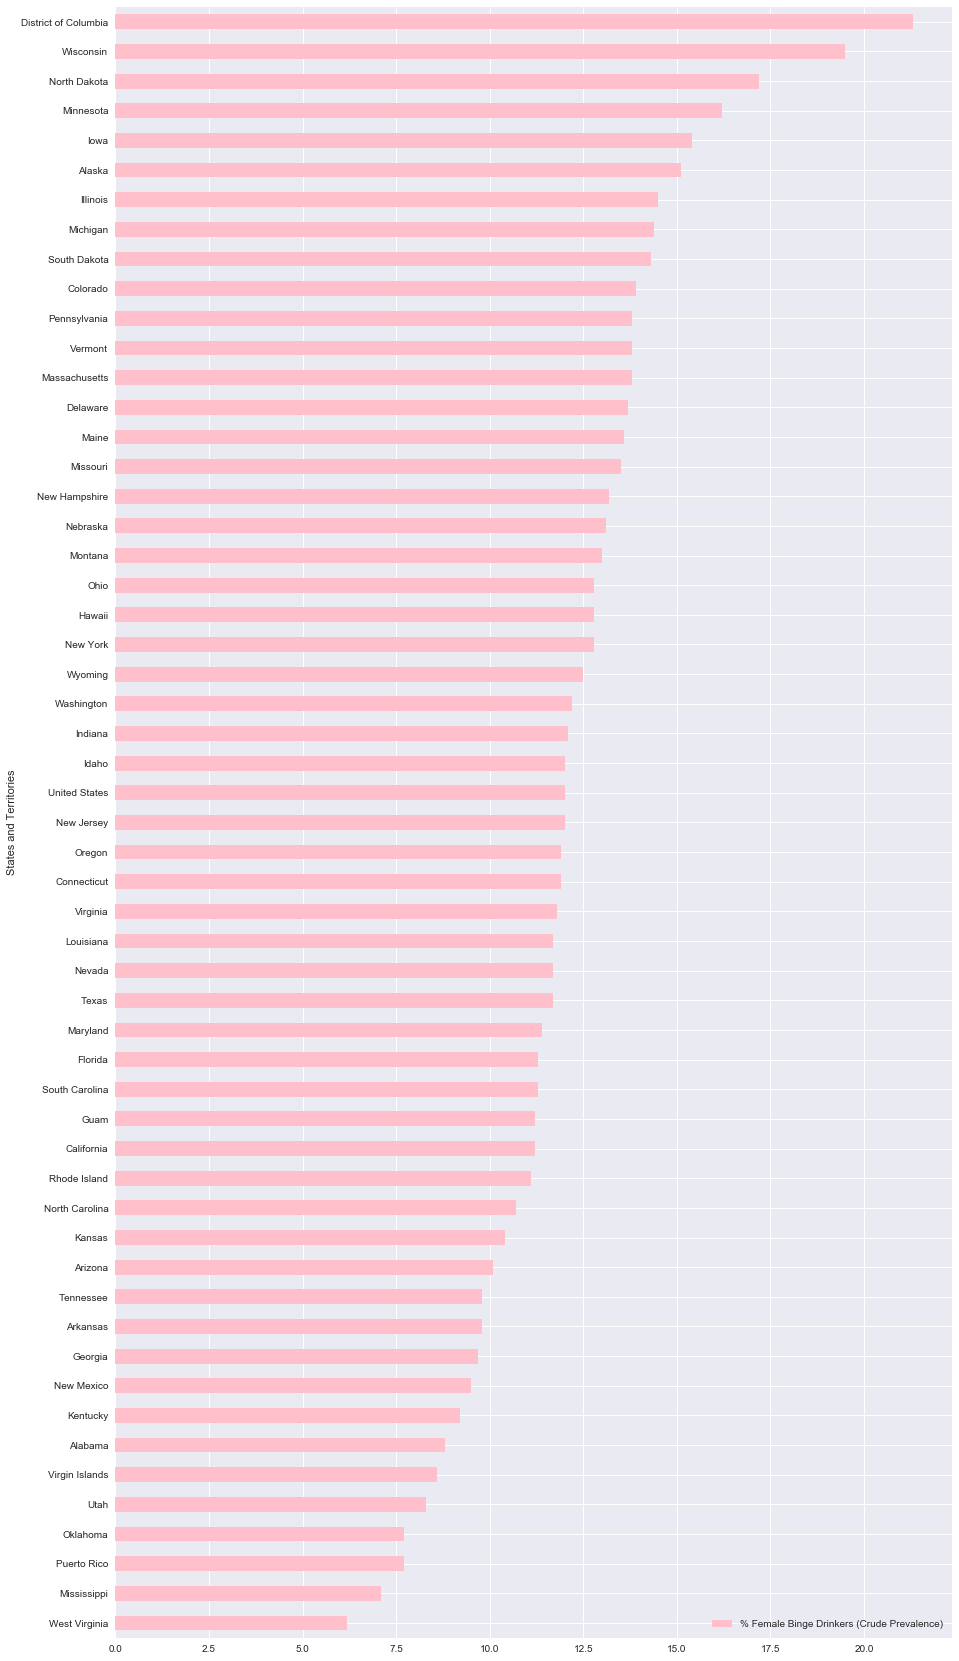

In [339]:
#Overall female binge drinkers (Crude Prevalence)
female_alcohol_cdi.set_index('States and Territories').plot.barh(stacked=True, color='pink',figsize=(15,30))

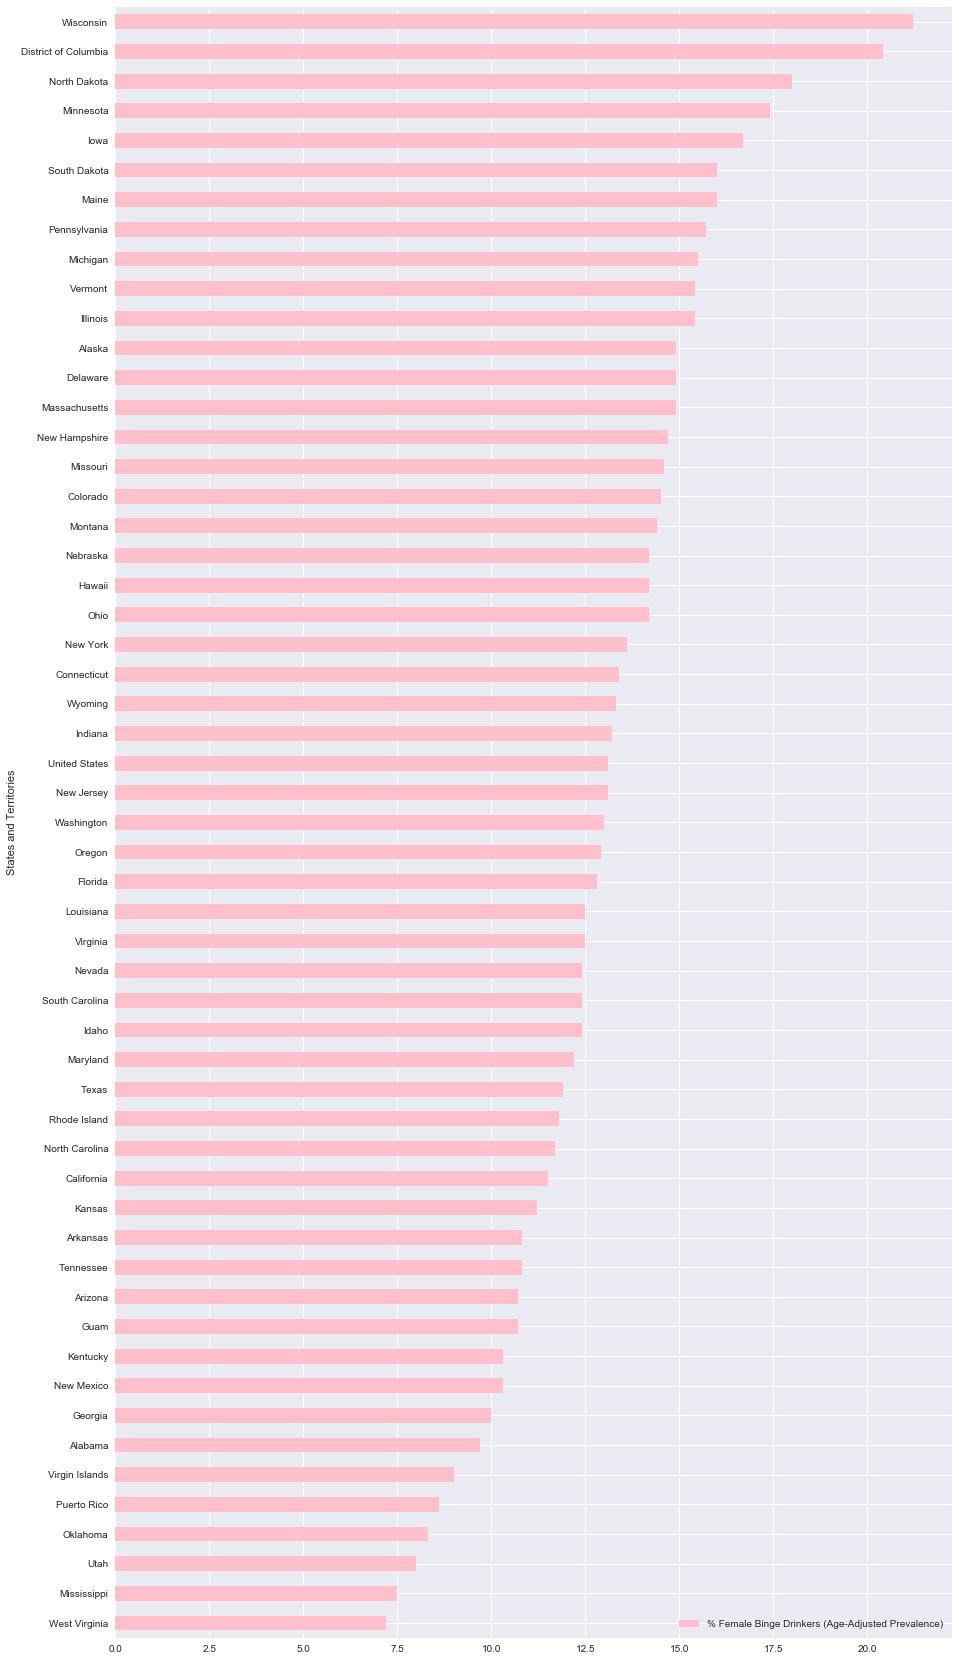

In [340]:
#Overall female binge drinkers (Age-adjusted Prevalence)
female_alcohol_cdi2.set_index('States and Territories').plot.barh(stacked=True, color='pink',figsize=(15,30))

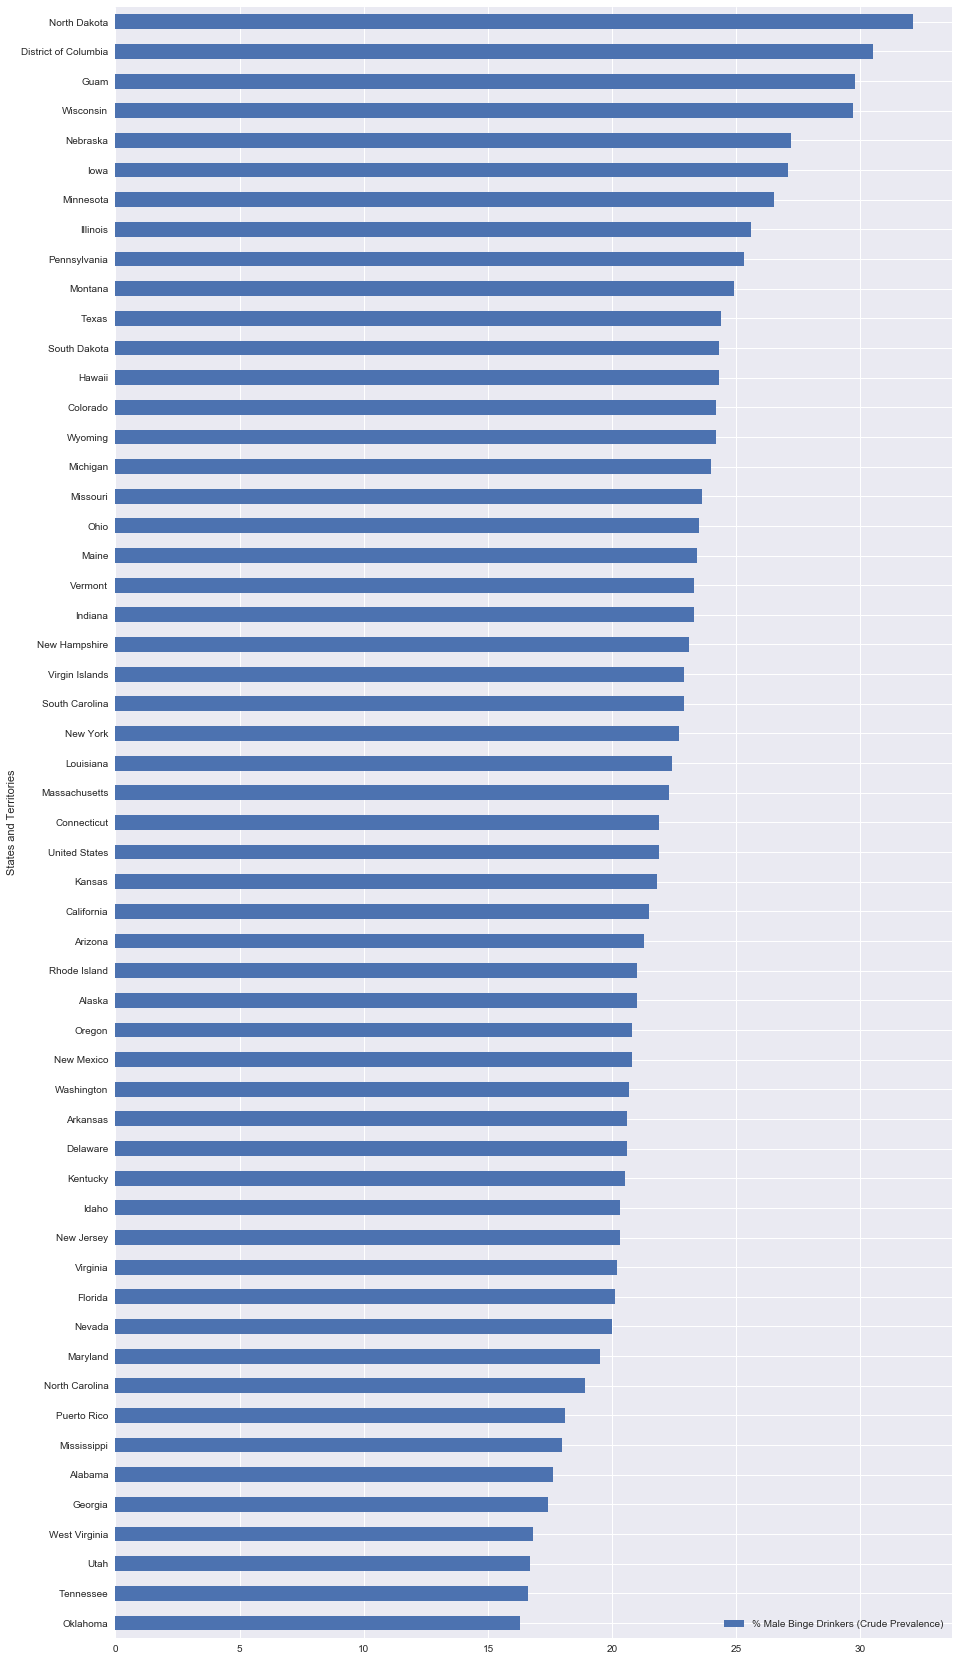

In [341]:
#Overall male binge drinking (crude prevalence)
male_alcohol_cdi.set_index('States and Territories').plot.barh(stacked=True,figsize=(15,30))

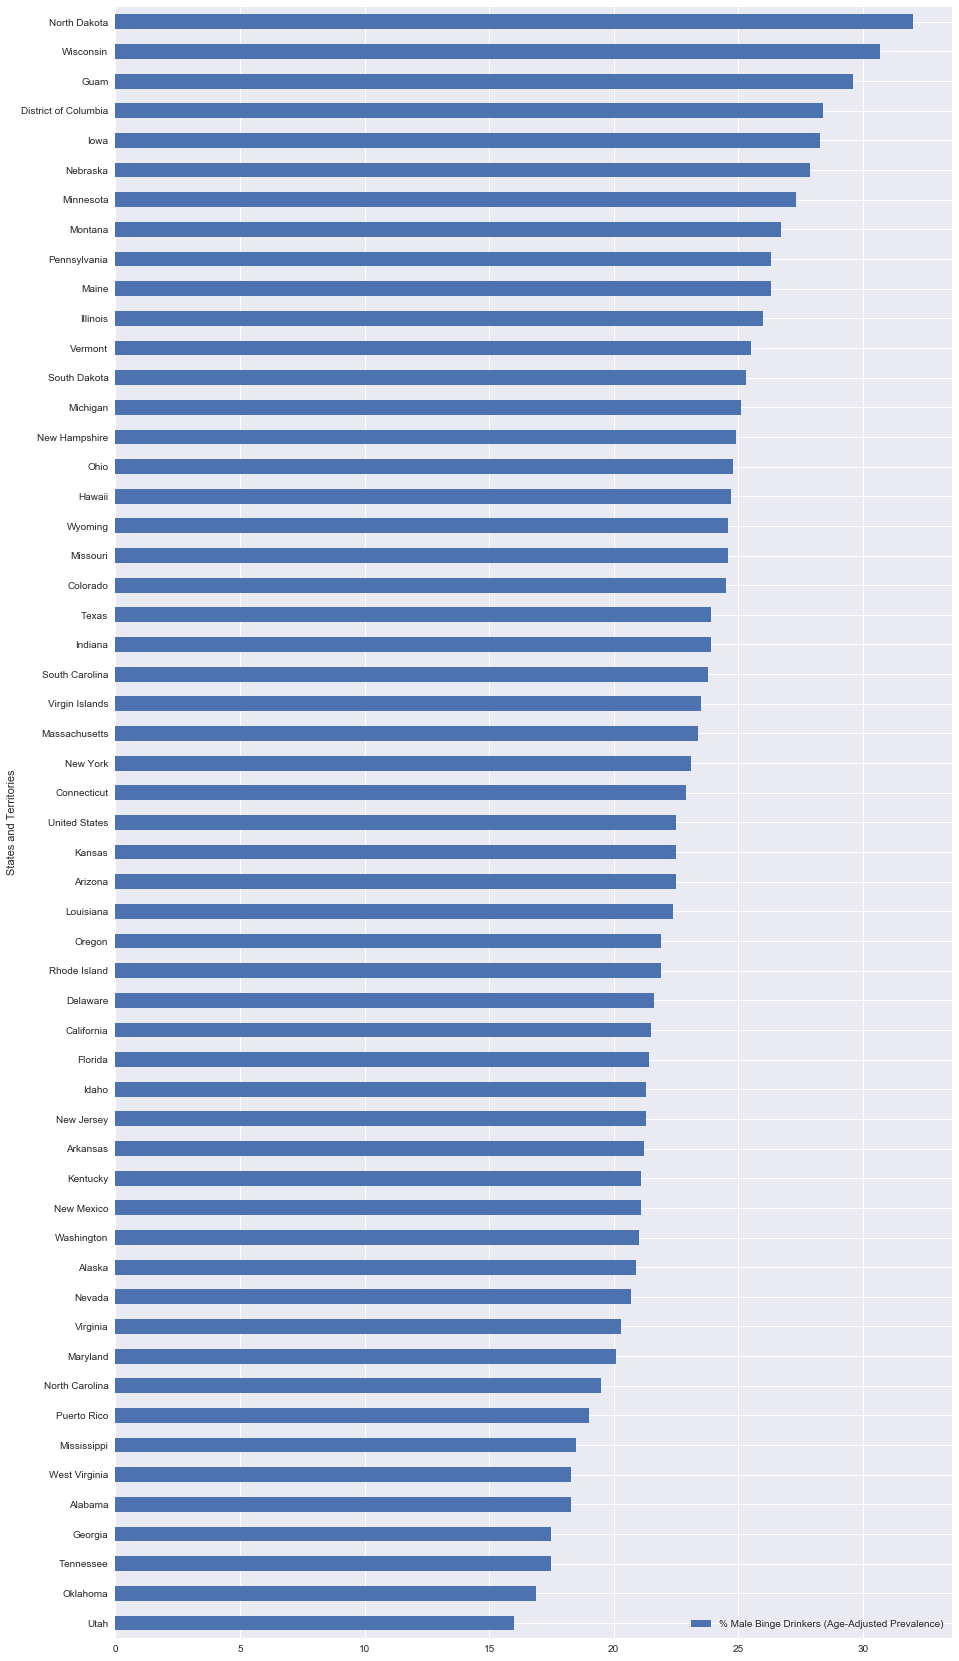

In [342]:
#Overall male binge drinking (Age-Adjusted Prevalence)
male_alcohol_cdi2.set_index('States and Territories').plot.barh(stacked=True,figsize=(15,30))

In [343]:
new_cdi = cdi_df[cdi_df["Topic"].str.contains('Alcohol')]
new_cdi = new_cdi[new_cdi["Stratification1"].str.contains("White")]
new_cdi = new_cdi[new_cdi["DataValueType"].str.contains('Crude')]
new_cdi = new_cdi[new_cdi["Question"].str.contains("Binge drinking prevalence among adults aged >= 18 years")]
new_cdi = new_cdi[['LocationDesc', 'DataValue']].copy()
new_cdi = new_cdi.rename(columns={'LocationDesc':'States and Territories'})
new_cdi = new_cdi.sort_values(by=['DataValue'])

white_alcohol_cdi = new_cdi.rename(columns={'DataValue': '% White, non-Hispanic Binge Drinkers (Crude Prevalence)'})

In [344]:
new_cdi2 = cdi_df[cdi_df["Topic"].str.contains('Alcohol')]
new_cdi2 = new_cdi2[new_cdi2["Stratification1"].str.contains("Black")]
new_cdi2 = new_cdi2[new_cdi2["DataValueType"].str.contains('Crude')]
new_cdi2 = new_cdi2[new_cdi2["Question"].str.contains("Binge drinking prevalence among adults aged >= 18 years")]
new_cdi2 = new_cdi2[['LocationDesc', 'DataValue']].copy()
new_cdi2 = new_cdi2.rename(columns={'LocationDesc':'States and Territories'})
new_cdi2 = new_cdi2.sort_values(by=['DataValue'])


black_alcohol_cdi = new_cdi.rename(columns={'DataValue': '% Black, non-Hispanic Binge Drinkers (Crude Prevalence)'})

In [345]:
new_cdi3 = cdi_df[cdi_df["Topic"].str.contains('Alcohol')]
new_cdi3 = new_cdi3[new_cdi3["Stratification1"] == 'Hispanic']
new_cdi3 = new_cdi3[new_cdi3["DataValueType"].str.contains('Crude')]
new_cdi3 = new_cdi3[new_cdi3["Question"].str.contains("Binge drinking prevalence among adults aged >= 18 years")]
new_cdi3 = new_cdi3[['LocationDesc', 'DataValue']].copy()
new_cdi3 = new_cdi3.rename(columns={'LocationDesc':'States and Territories'})
new_cdi3 = new_cdi3.sort_values(by=['DataValue'])

hispanic_alcohol_cdi = new_cdi3.rename(columns={'DataValue': '% Hispanic Binge Drinkers (Crude Prevalence)'})

In [346]:
new_cdi4 = cdi_df[cdi_df["Topic"].str.contains('Alcohol')]
new_cdi4 = new_cdi4[new_cdi4["Stratification1"].str.contains("Other")]
new_cdi4 = new_cdi4[new_cdi4["DataValueType"].str.contains('Crude')]
new_cdi4 = new_cdi4[new_cdi4["Question"].str.contains("Binge drinking prevalence among adults aged >= 18 years")]
new_cdi4 = new_cdi4[['LocationDesc', 'DataValue']].copy()
new_cdi4 = new_cdi4.rename(columns={'LocationDesc':'States and Territories'})
new_cdi4 = new_cdi4.sort_values(by=['DataValue'])

other_alcohol_cdi = new_cdi4.rename(columns={'DataValue': '% Other, non-Hispanic Binge Drinkers (Crude Prevalence)'})

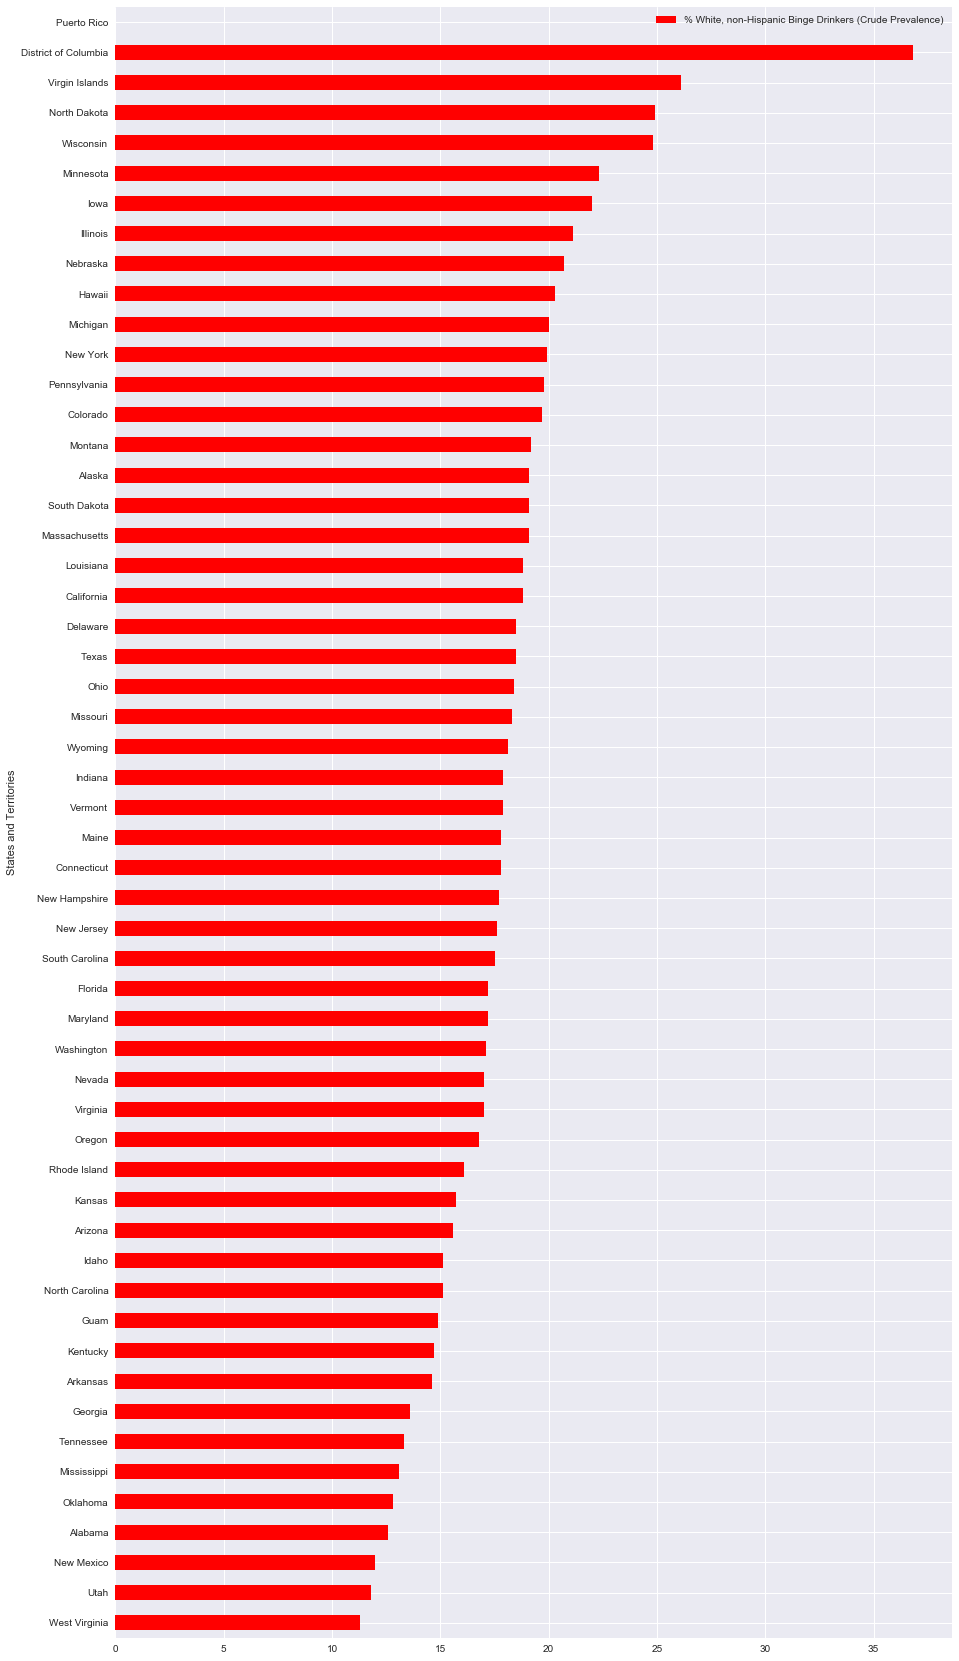

In [347]:
white_alcohol_cdi.set_index('States and Territories').plot.barh(stacked=True, color='red', figsize=(15,30))

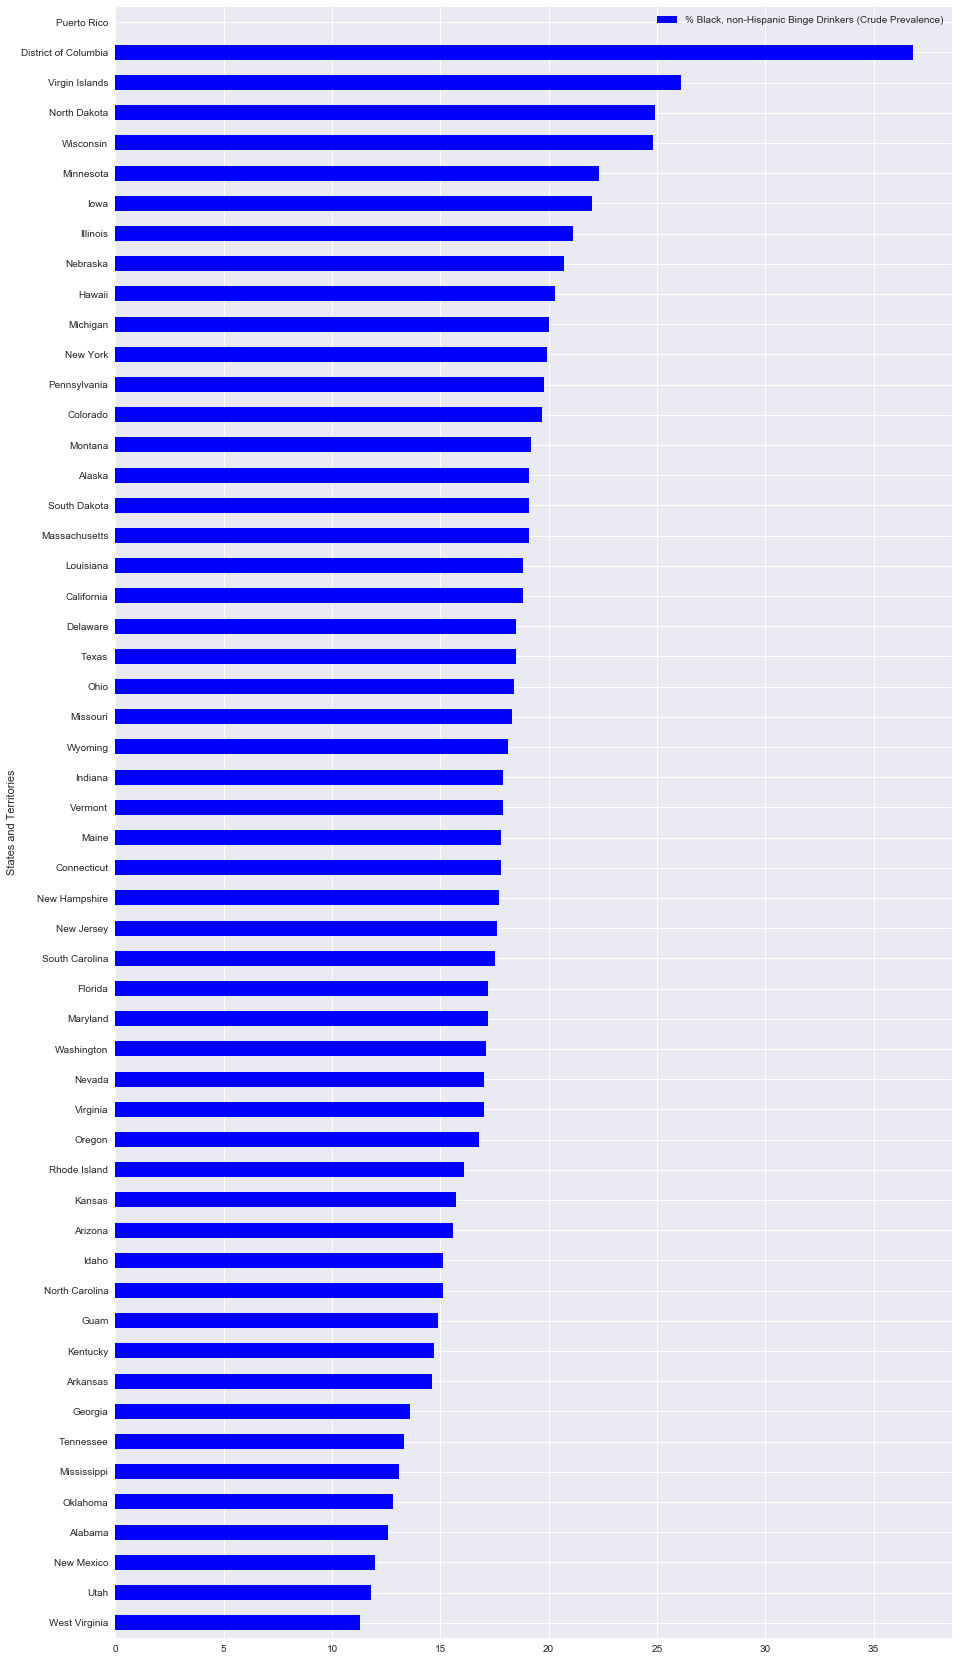

In [348]:
black_alcohol_cdi.set_index('States and Territories').plot.barh(stacked=True, color='blue',figsize=(15,30))

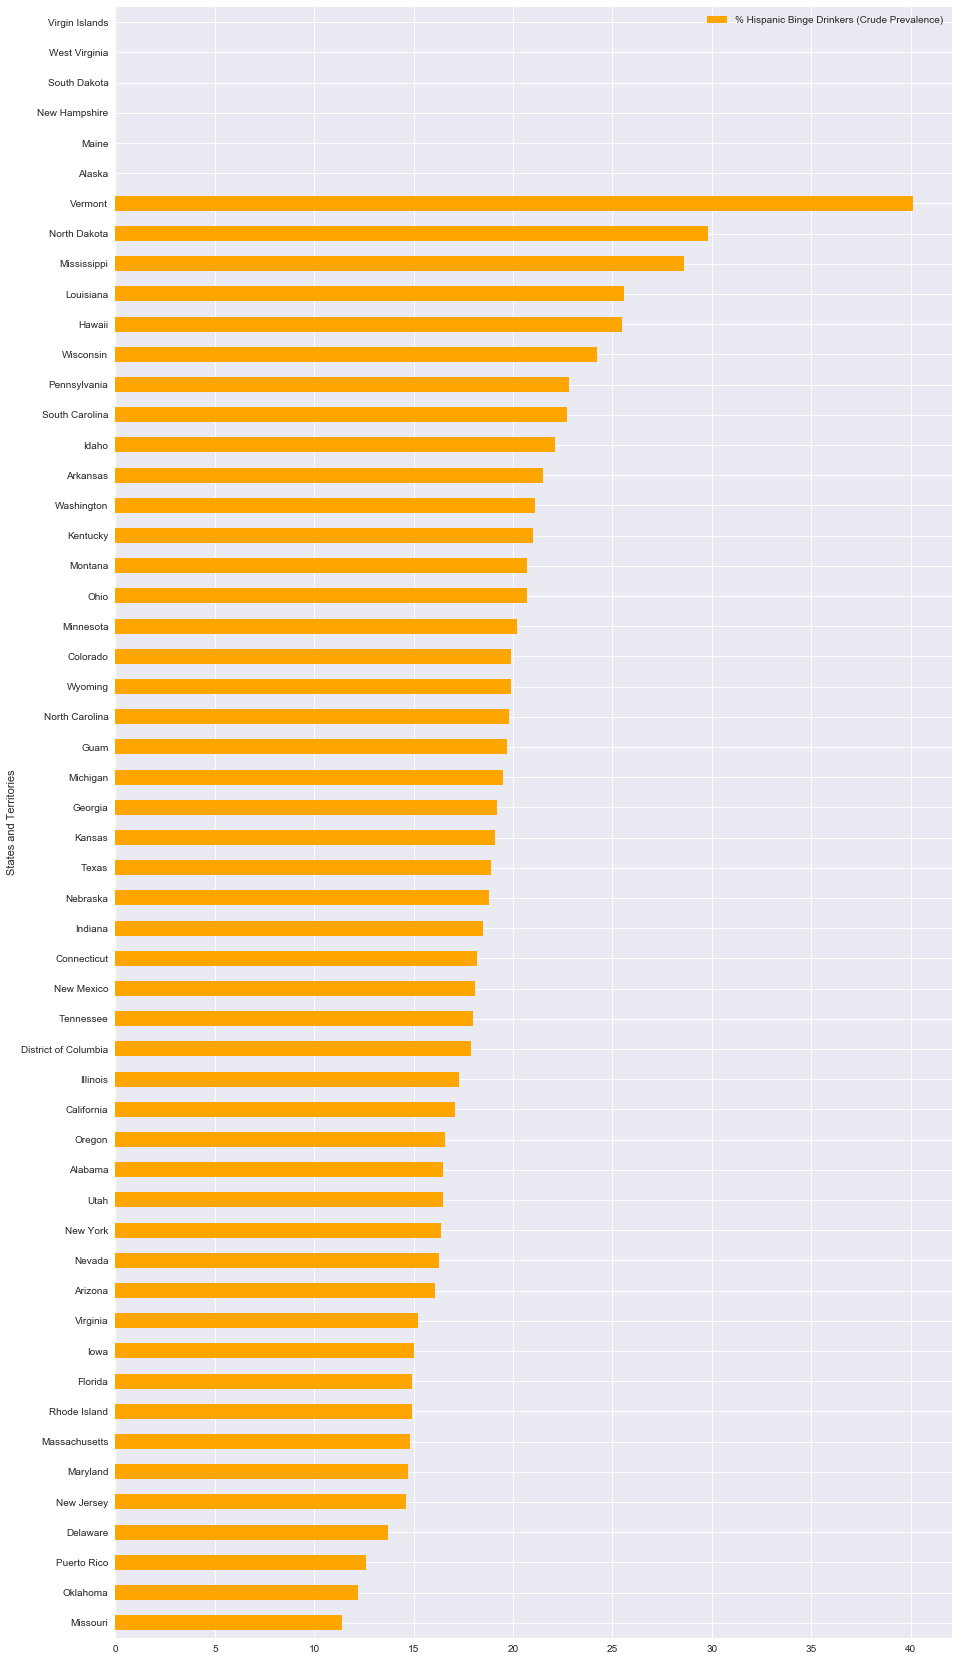

In [349]:
hispanic_alcohol_cdi.set_index('States and Territories').plot.barh(stacked=True, color='orange',figsize=(15,30))

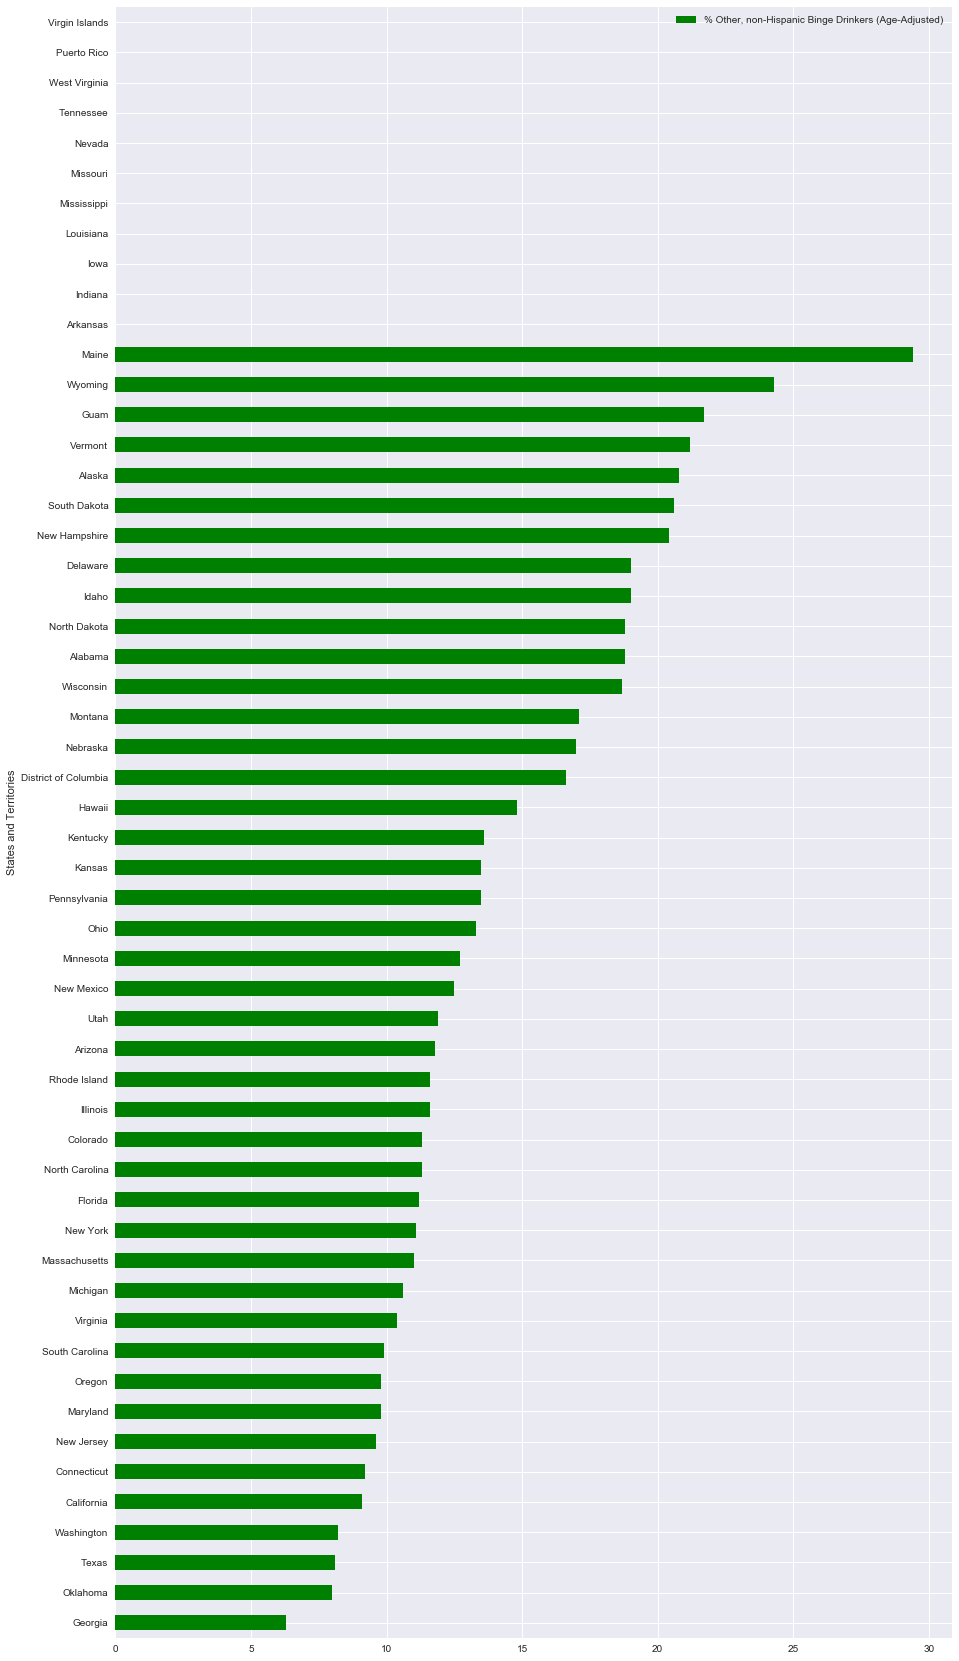

In [350]:
other_alcohol_cdi2.set_index('States and Territories').plot.barh(stacked=True, color='green',figsize=(15,30))

In [351]:
new_cdi = cdi_df[cdi_df["Topic"].str.contains('Alcohol')]
new_cdi = new_cdi[new_cdi["Stratification1"].str.contains("White")]
new_cdi = new_cdi[new_cdi["DataValueType"].str.contains('Age-adjusted')]
new_cdi = new_cdi[new_cdi["Question"].str.contains("Binge drinking prevalence among adults aged >= 18 years")]
new_cdi = new_cdi[['LocationDesc', 'DataValue']].copy()
new_cdi = new_cdi.rename(columns={'LocationDesc':'States and Territories'})
new_cdi = new_cdi.sort_values(by=['DataValue'])

white_alcohol_cdi2 = new_cdi.rename(columns={'DataValue': '% White, non-Hispanic Binge Drinkers (Age-adjusted)'})

In [352]:
new_cdi2 = cdi_df[cdi_df["Topic"].str.contains('Alcohol')]
new_cdi2 = new_cdi2[new_cdi2["Stratification1"].str.contains("Black")]
new_cdi2 = new_cdi2[new_cdi2["DataValueType"].str.contains('Age-adjusted')]
new_cdi2 = new_cdi2[new_cdi2["Question"].str.contains("Binge drinking prevalence among adults aged >= 18 years")]
new_cdi2 = new_cdi2[['LocationDesc', 'DataValue']].copy()
new_cdi2 = new_cdi2.rename(columns={'LocationDesc':'States and Territories'})
new_cdi2 = new_cdi2.sort_values(by=['DataValue'])

black_alcohol_cdi2 = new_cdi2.rename(columns={'DataValue': '% Black, non-Hispanic Binge Drinkers (Age-Adjusted)'})

In [353]:
new_cdi3 = cdi_df[cdi_df["Topic"].str.contains('Alcohol')]
new_cdi3 = new_cdi3[new_cdi3["Stratification1"] == 'Hispanic']
new_cdi3 = new_cdi3[new_cdi3["DataValueType"].str.contains('Age-adjusted')]
new_cdi3 = new_cdi3[new_cdi3["Question"].str.contains("Binge drinking prevalence among adults aged >= 18 years")]
new_cdi3 = new_cdi3[['LocationDesc', 'DataValue']].copy()
new_cdi3 = new_cdi3.rename(columns={'LocationDesc':'States and Territories'})
new_cdi3 = new_cdi3.sort_values(by=['DataValue'])

hispanic_alcohol_cdi2 = new_cdi3.rename(columns={'DataValue': '% Hispanic Binge Drinkers (Age-Adjusted)'})

In [354]:
new_cdi4 = cdi_df[cdi_df["Topic"].str.contains('Alcohol')]
new_cdi4 = new_cdi4[new_cdi4["Stratification1"].str.contains("Other")]
new_cdi4 = new_cdi4[new_cdi4["DataValueType"].str.contains('Age-adjusted')]
new_cdi4 = new_cdi4[new_cdi4["Question"].str.contains("Binge drinking prevalence among adults aged >= 18 years")]
new_cdi4 = new_cdi4[['LocationDesc', 'DataValue']].copy()
new_cdi4 = new_cdi4.rename(columns={'LocationDesc':'States and Territories'})
new_cdi4 = new_cdi4.sort_values(by=['DataValue'])

other_alcohol_cdi2 = new_cdi4.rename(columns={'DataValue': '% Other, non-Hispanic Binge Drinkers (Age-Adjusted)'})

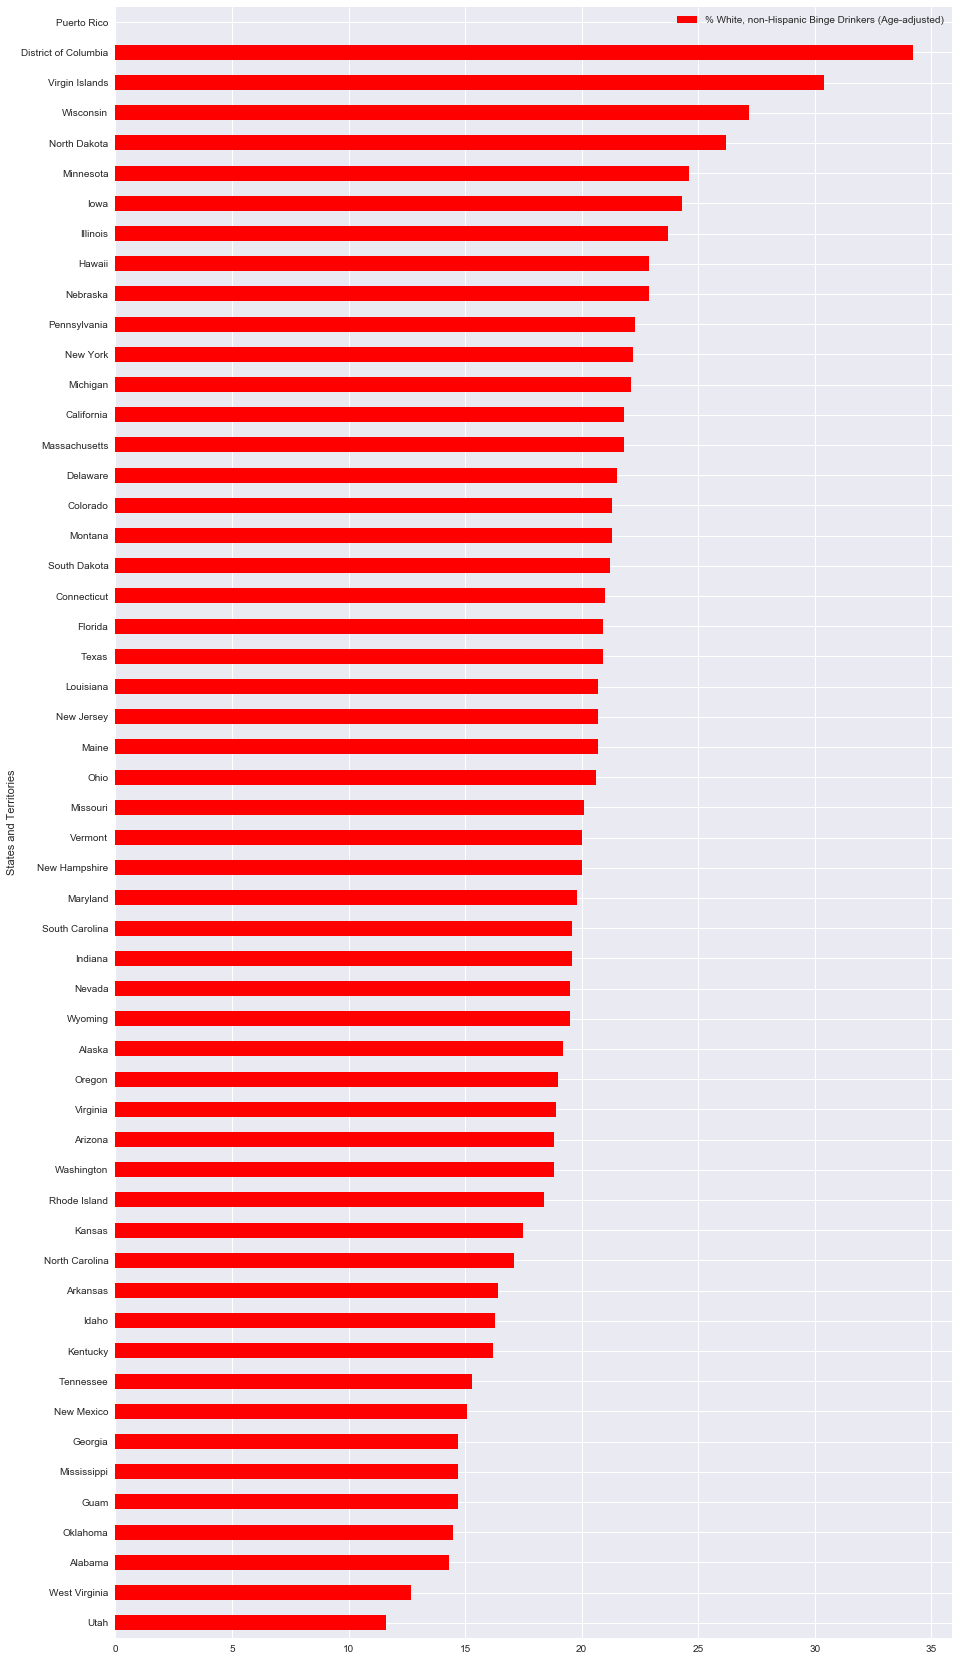

In [355]:

white_alcohol_cdi2.set_index('States and Territories').plot.barh(stacked=True, color='red', figsize=(15,30))

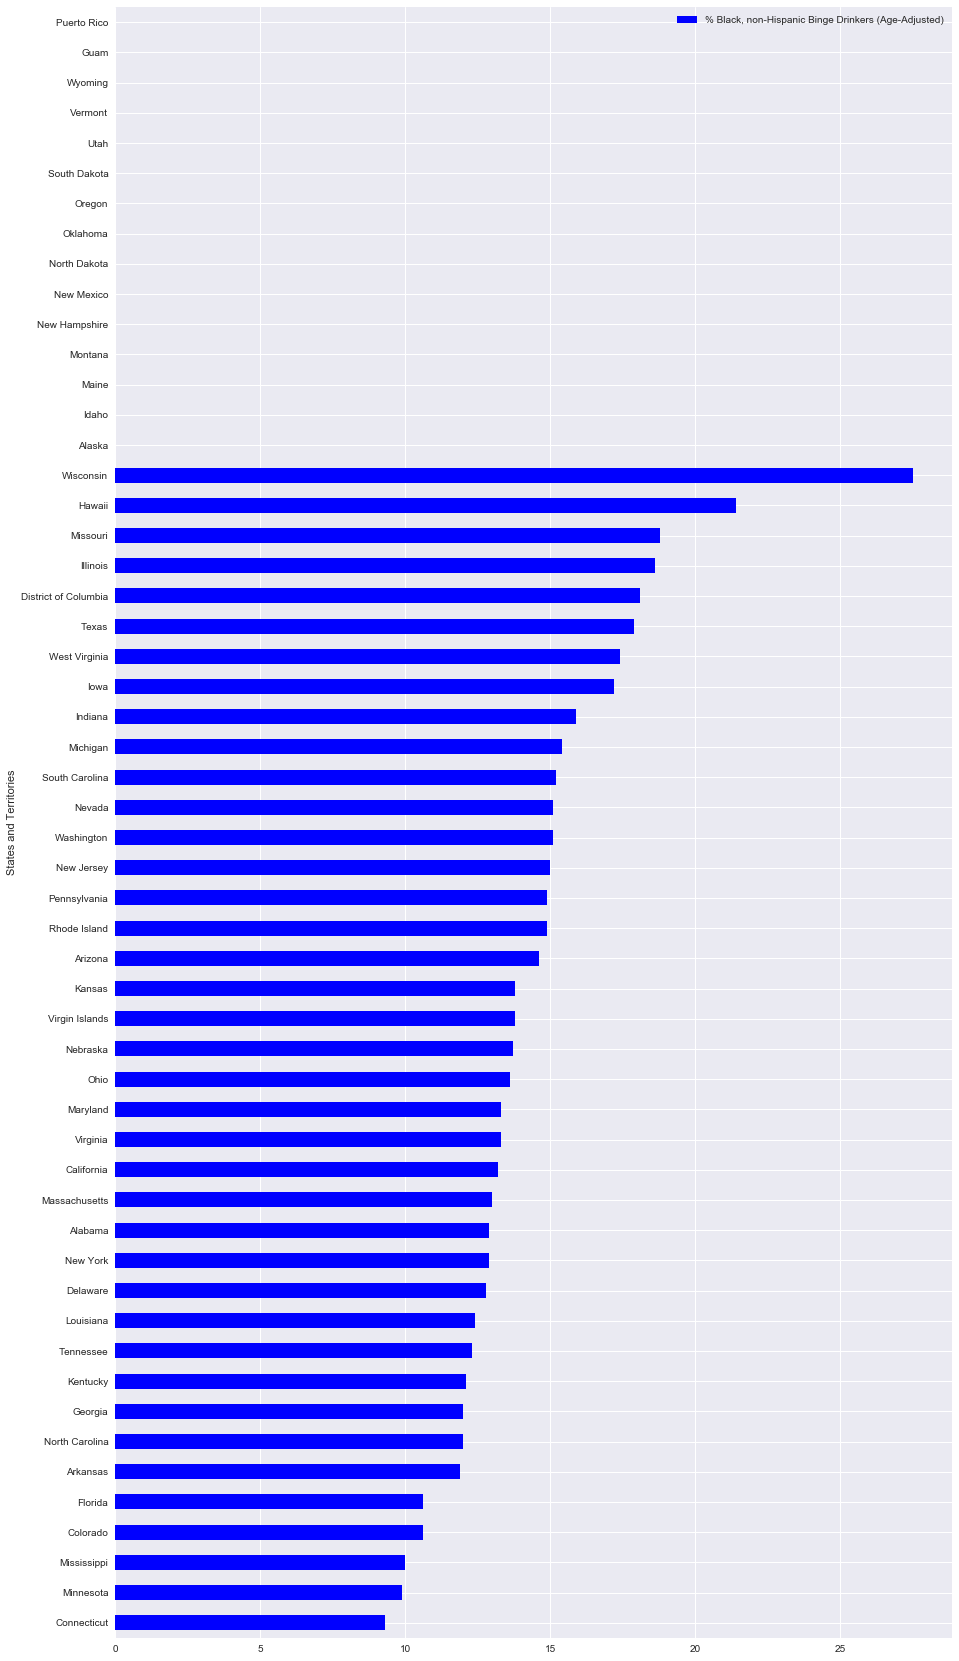

In [356]:
black_alcohol_cdi2.set_index('States and Territories').plot.barh(stacked=True, color='blue',figsize=(15,30))

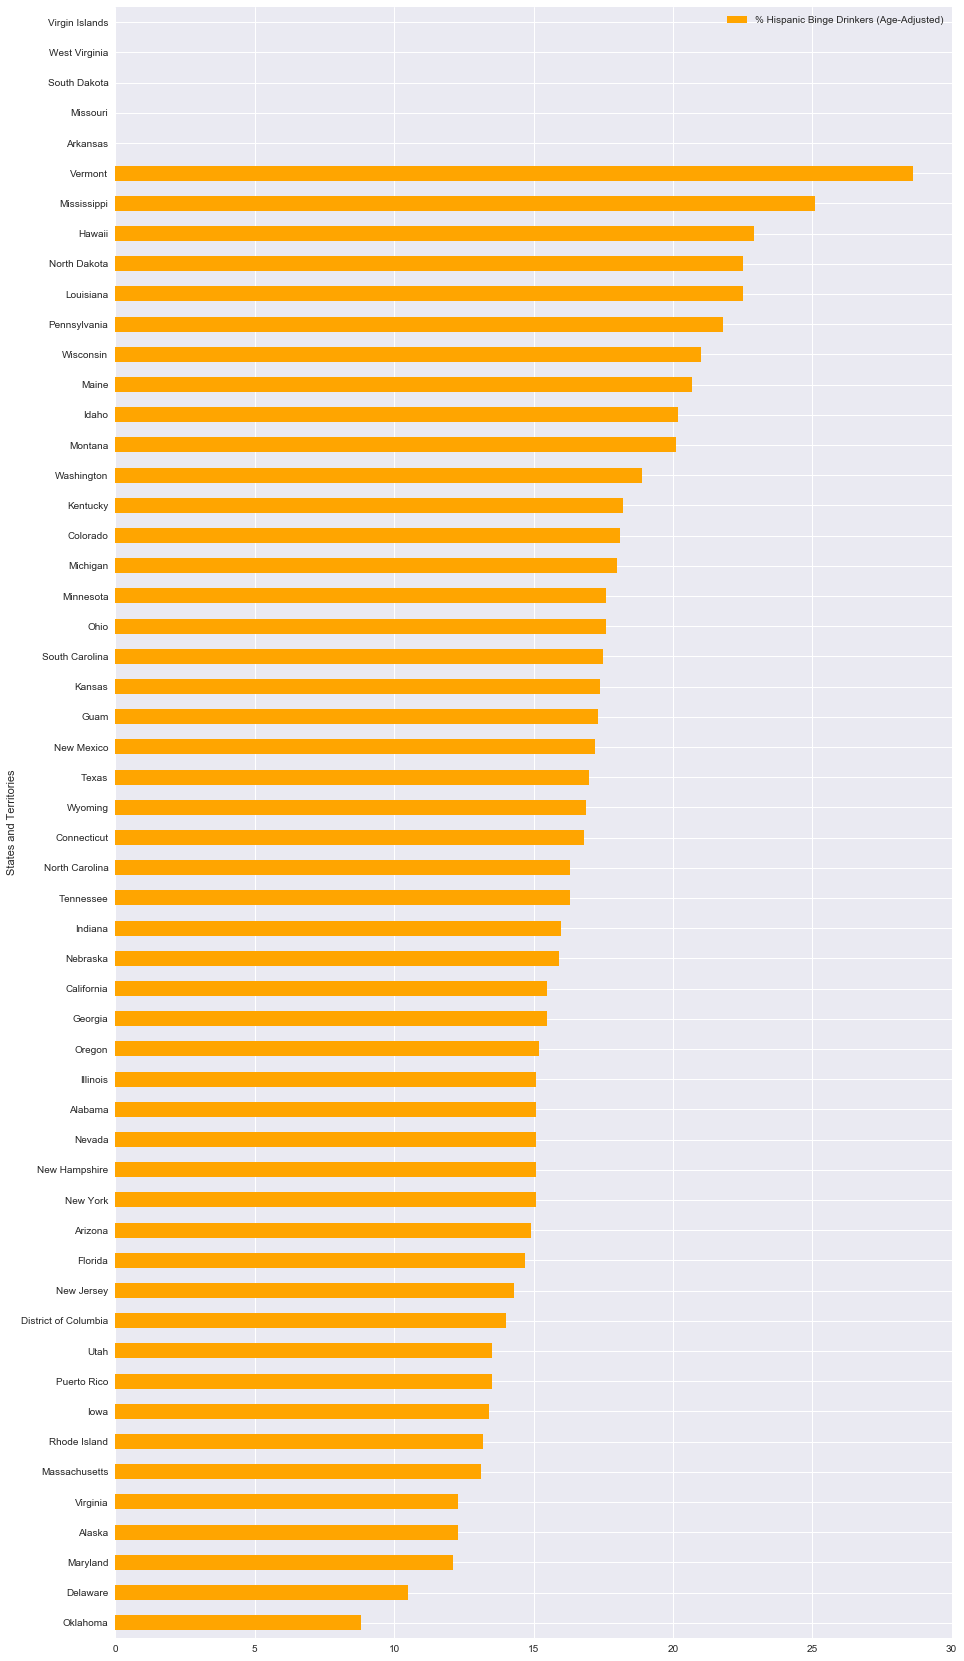

In [357]:
hispanic_alcohol_cdi2.set_index('States and Territories').plot.barh(stacked=True, color='orange',figsize=(15,30))

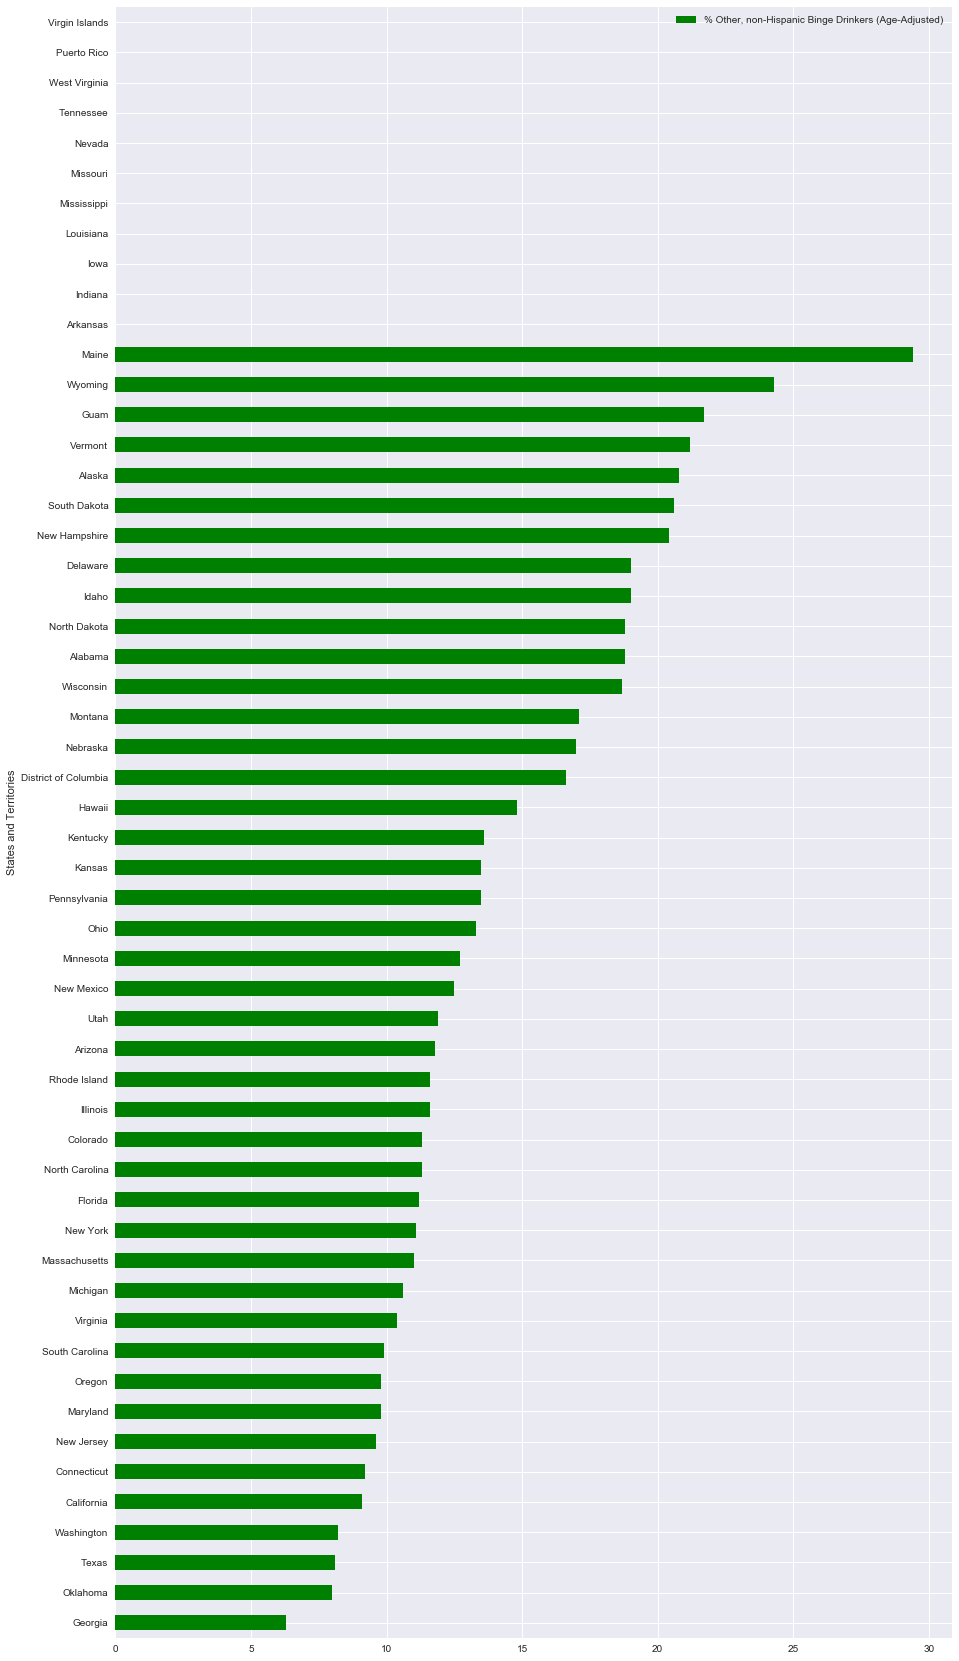

In [358]:
other_alcohol_cdi2.set_index('States and Territories').plot.barh(stacked=True, color='green',figsize=(15,30))